## What is the protein domain profile of genes from the same module ? 


In [1]:
from intermine.webservice import Service
import numpy as np
import scipy.io
import seaborn as sns
from scipy import stats, optimize, interpolate
import pandas as pd
from collections import defaultdict 
import math
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
from scipy import stats
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import os, fnmatch

## Selecting the modules to evaluate the protein domains 

In [2]:
import os
script_dir = os.path.dirname('__file__') #<-- absolute dir the script is in
rel_path_domains="datasets/proteins-domains-from-Pfam.xlsx"

abs_file_path_domains = os.path.join(script_dir, rel_path_domains)

os.chdir('../') #<-- for binder os.chdir('../')
my_path_domains=abs_file_path_domains
data_domains=pd.read_excel(my_path_domains,header=0,index_col='Unnamed: 0')
data_domains=data_domains.dropna()

In [3]:
data_domains.head()

,name,domain-name,domain-descrip,domain-start,domain-end,domain-method,domain-id
0,AAC1,PF00153,Mito_carr; Mitochondrial substrate/solute carrier,10,106,Pfam,2056375
1,AAC1,PF00153,Mito_carr; Mitochondrial substrate/solute carrier,116,210,Pfam,2056376
2,AAC1,PF00153,Mito_carr; Mitochondrial substrate/solute carrier,217,304,Pfam,2056377
3,AAC3,PF00153,Mito_carr; Mitochondrial substrate/solute carrier,9,105,Pfam,2062638
4,AAC3,PF00153,Mito_carr; Mitochondrial substrate/solute carrier,115,208,Pfam,2062639


In [137]:
pathways=[ 'galactose degradation','phospholipid biosynthesis', "ethanol degradation"]
biological_processes_slim=["cell budding","lipid binding","cytokinesis"]
biological_processes_goterm=["cell morphogenesis involved in conjugation with cellular fusion","budding cell apical bud growth","establishment of cell polarity"]

In [112]:
service = Service('https://yeastmine.yeastgenome.org/yeastmine/service', token = '11d7t1Y007Fa97c82f27')
query = service.new_query("Gene")
query.add_constraint("goAnnotation.ontologyTerm.parents", "GOTerm")
query.add_view(
     "symbol", "goAnnotation.evidence.code.annotType",
     "goAnnotation.ontologyTerm.parents.name"
)
query.add_constraint("goAnnotation.qualifier", "!=", "NOT", code = "C")
query.add_constraint("goAnnotation.qualifier", "IS NULL", code = "D")
query.add_constraint("goAnnotation.evidence.code.annotType", "=", "manually curated", code = "F")
query.add_constraint("goAnnotation.ontologyTerm.parents.name", "=", "cell morphogenesis involved in conjugation with cellular fusion", code = "G")
query.set_logic("(C or D) and F and G")

data_toy=defaultdict(dict)

for row,counter in zip(query.rows(),np.arange(0,len(query.rows()))):

     data_toy['gene-name'][counter]=row["symbol"]

data_toy_pd=pd.DataFrame(data_toy)
data_gal_pathway=data_toy_pd.drop_duplicates()

In [114]:
def from_go_to_genes(go,label):
    #label=["GOTerm" or "GOSlimTerm"]
    service = Service('https://yeastmine.yeastgenome.org/yeastmine/service', token = '11d7t1Y007Fa97c82f27')
    query = service.new_query("Gene")
    query.add_constraint("goAnnotation.ontologyTerm.parents", label)
    query.add_view(
        "symbol", "goAnnotation.evidence.code.annotType",
        "goAnnotation.ontologyTerm.parents.name"
    )
    query.add_constraint("goAnnotation.qualifier", "!=", "NOT", code = "C")
    query.add_constraint("goAnnotation.qualifier", "IS NULL", code = "D")
    query.add_constraint("goAnnotation.evidence.code.annotType", "=", "manually curated", code = "F")
    query.add_constraint("goAnnotation.ontologyTerm.parents.name", "=", go, code = "G")
    query.set_logic("(C or D) and F and G")

    data_toy=defaultdict(dict)

    for row,counter in zip(query.rows(),np.arange(0,len(query.rows()))):

        data_toy['gene-name'][counter]=row["symbol"]
        data_toy['evidence'][counter]=row["goAnnotation.evidence.code.annotType"]
        data_toy['annotation'][counter]=row["goAnnotation.ontologyTerm.parents.name"]


    data_toy_pd=pd.DataFrame(data_toy)
    data=data_toy_pd.drop_duplicates()

    data.index=np.arange(0,len(data))
    return data

In [138]:
go=biological_processes_goterm[2]
data=from_go_to_genes(go,label='GOTerm')

In [139]:
data

,gene-name,evidence,annotation
0,ACT1,manually curated,establishment of cell polarity
1,BUD6,manually curated,establishment of cell polarity
2,ARP1,manually curated,establishment of cell polarity
3,SLA2,manually curated,establishment of cell polarity
4,SNF1,manually curated,establishment of cell polarity
...,...,...,...
62,SHO1,manually curated,establishment of cell polarity
63,MYO2,manually curated,establishment of cell polarity
64,DMA2,manually curated,establishment of cell polarity
65,DMA1,manually curated,establishment of cell polarity


In [140]:
# Selecting the meaningful columns in the respective dataset
domain_id_list=data_domains['domain-name']
query_gene=data['gene-name']

# Initialising the arrays
protein_a_list=[]

population = np.arange(0,len(query_gene))


for m in population:

    protein_a=data_domains[data_domains['name']==query_gene[m]]
    protein_a_list.append(protein_a['domain-name'].tolist())
    

    

In [141]:
def remove_empty_domains(protein_list_search):
    index=[]
    for i in np.arange(0,len(protein_list_search)):
        if protein_list_search[i]==[]:
            index.append(i) ## index of empty values for the protein_a_list meaning they dont have any annotated domain

    y=[x for x in np.arange(0,len(protein_list_search)) if x not in index] # a list with non empty values from protein_a list

    protein_list_search_new=[]
    
    for i in y:
        protein_list_search_new.append(protein_list_search[i])
        
    return protein_list_search_new

## evaluating the function

protein_a_list_new=remove_empty_domains(protein_a_list)

In [142]:
print('The empty domain in the data were:', len(protein_a_list)-len(protein_a_list_new), 'out of', len(protein_a_list),'domains')

The empty domain in the data were: 14 out of 67 domains


In [143]:
protein_module=[]

for i in np.arange(0,len(protein_a_list_new)):
    protein_module.append(np.unique(protein_a_list_new[i]))# just taking the unique domains per protein in the module 
protein_module=np.concatenate(protein_module, axis=0 )

In [144]:
unique_domains,index_domains,index_counts=np.unique(protein_module,return_index=True,return_counts=True) # counting how many proteins have the same domain per module 

In [145]:
stats_module=pd.DataFrame()
stats_module['unique-domains']=unique_domains
stats_module['counts-each-domains']=index_counts
stats_module['index-for-original-domains-array']=index_domains
stats_module['ratio-of-sharing']=(index_counts-1)/len(unique_domains)

stats_module.set_index=np.arange(0,len(stats_module))


## Sorting the dataframe by the ratio of sharing 

In [146]:
stats_module['domain-descrip']=np.zeros_like(unique_domains)
stats_module['protein-name']=np.zeros_like(unique_domains)
stats_module['module-name']=np.zeros_like(unique_domains)
for i in np.arange(0,len(unique_domains)):
    stats_module['domain-descrip'][i]=data_domains[data_domains['domain-name']==unique_domains[i]]['domain-descrip'].tolist()[0]
    names=data_domains[data_domains['domain-name']==unique_domains[i]]['name'].tolist()
    stats_module['protein-name'][i]=set(names).intersection(query_gene) # print the intresection of all proteins with those domains with the protein from the module 
    stats_module['module-name'][i]=go
stats_module_sorted=stats_module.sort_values(by=['ratio-of-sharing'],ascending=False)
stats_module_sorted

,unique-domains,counts-each-domains,index-for-original-domains-array,ratio-of-sharing,domain-descrip,protein-name,module-name
0,PF00018,3,64,0.027397,SH3_1; SH3 domain,"{MYO3, MYO5, SHO1}",establishment of cell polarity
3,PF00063,3,65,0.027397,"Myosin_head; Myosin head, motor domain","{MYO3, MYO5, MYO2}",establishment of cell polarity
4,PF00069,3,5,0.027397,Pkinase; Protein kinase domain,"{STE20, SNF1, BCK1}",establishment of cell polarity
5,PF00071,3,63,0.027397,Ras; Small GTPase superfamily,"{RHO2, CDC42, RSR1}",establishment of cell polarity
17,PF00620,2,41,0.013699,RhoGAP; Rho GTPase-activating protein domain,"{RGA1, BEM3}",establishment of cell polarity
...,...,...,...,...,...,...,...
9,PF00400,1,19,0.000000,WD40; WD40 repeat,{PWP2},establishment of cell polarity
39,PF06367,1,35,0.000000,"Drf_FH3; Formin, FH3 domain",{BNI1},establishment of cell polarity
40,PF06371,1,36,0.000000,"Drf_GBD; Formin, GTPase-binding domain",{BNI1},establishment of cell polarity
41,PF06395,1,46,0.000000,"CDC24; Cdc24/Scd1, N-terminal",{CDC24},establishment of cell polarity


Text(0.5, 1.0, 'Module:establishment of cell polarity')

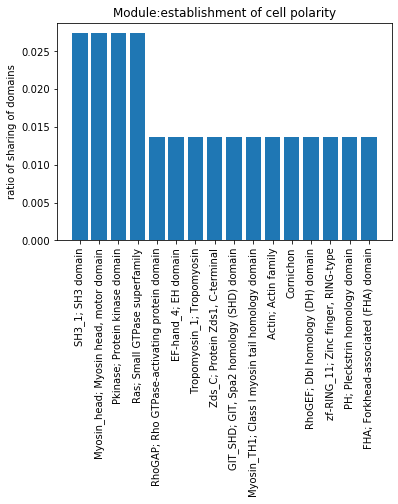

In [147]:
stats_module_sorted_diff_zero=stats_module_sorted[stats_module_sorted['ratio-of-sharing']!=0]
plt.bar(x=stats_module_sorted_diff_zero['domain-descrip'],height=stats_module_sorted_diff_zero['ratio-of-sharing']);
plt.xticks(rotation=90)
plt.ylabel('ratio of sharing of domains')
plt.title('Module:' + go)